In [119]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd

In [2]:
places = gpd.read_file('../shapes/tl_2019_06_place/')
places = places[places.STATEFP == '06']
places = places.to_crs(epsg=4326)
places['clean_city'] = [x.lower() for x in places.NAME]
all_places = np.unique(places.clean_city)
places.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,clean_city
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,G4110,A,6148696,0,+34.2886519,-118.4362413,"POLYGON ((-118.45601 34.28490, -118.45414 34.2...",san fernando
1,06,14190,02409487,0614190,Cloverdale,Cloverdale city,25,C1,N,N,G4110,A,8107251,0,+38.7961433,-123.0150596,"POLYGON ((-123.03512 38.78701, -123.03510 38.7...",cloverdale
2,06,16560,02410240,0616560,Cotati,Cotati city,25,C1,N,N,G4110,A,4869301,8380,+38.3284920,-122.7100491,"POLYGON ((-122.72960 38.33349, -122.72951 38.3...",cotati
3,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56675175,26959120,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29711 34.34463, -119.2970...",san buenaventura (ventura)
4,06,30014,02410601,0630014,Glendora,Glendora city,25,C1,N,N,G4110,A,50527933,400123,+34.1449643,-117.8478035,"POLYGON ((-117.89005 34.14675, -117.89005 34.1...",glendora


In [133]:
census_data = pd.read_csv('../data/econ_census_all_sectors.csv')
census_data['NAMELSAD'] = [x.split(', California')[0] for x in census_data['Geographic Area Name (NAME)']]
census_data = census_data[census_data['Meaning of Tax status code (TAXSTAT_LABEL)'] == 'All establishments']
census_data['RCPTOT'] = census_data['Sales, value of shipments, or revenue ($1,000) (RCPTOT)']
census_data['PAYANN'] = census_data['Annual payroll ($1,000) (PAYANN)']
census_data['NAICS'] = census_data['2017 NAICS code (NAICS2017)']
frame = None
code_subset = ['44-45', '72']
subset = census_data[census_data.NAICS.isin(code_subset)]
for field in ['RCPTOT']:
    thing = subset.pivot(index='NAMELSAD', columns='NAICS', values=field)
    thing = thing.rename(columns=lambda x: x + '_' + field)
    frame = pd.concat([frame, thing], axis=1)
frame.head()

NAICS,44-45_RCPTOT,72_RCPTOT
NAMELSAD,,
Acton CDP,"57,225",D
Adelanto city,"68,095","12,793"
Agoura Hills city,"360,799","87,807"
Agua Dulce CDP,"4,576",D
Alameda city,"654,991","241,375"


In [134]:
arber_df = pd.read_csv('../data/TRU_from_ARBER.csv')
merged = pd.merge(arber_df, places.groupby(['clean_city','NAME','NAMELSAD']).mean().reset_index(), on='clean_city')
companies = merged.groupby(['clean_city','NAME','NAMELSAD']).count()[['Company']]
companies = companies.rename({'Company':'num_firms'}, axis=1)
companies = companies.reset_index()
companies

/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_86065/1071082915.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged = pd.merge(arber_df, places.groupby(['clean_city','NAME','NAMELSAD']).mean().reset_index(), on='clean_city')


,clean_city,NAME,NAMELSAD,num_firms
0,adelanto,Adelanto,Adelanto city,2
1,alamo,Alamo,Alamo CDP,1
2,alhambra,Alhambra,Alhambra city,6
3,aliso viejo,Aliso Viejo,Aliso Viejo city,1
4,altadena,Altadena,Altadena CDP,1
...,...,...,...,...
395,woodlake,Woodlake,Woodlake city,1
396,woodland,Woodland,Woodland city,7
397,yorba linda,Yorba Linda,Yorba Linda city,1
398,yuba city,Yuba City,Yuba City city,141


In [132]:
survey = pd.read_csv('../data/econ_survey_all_sectors.csv')
survey['NAMELSAD'] = [x.split(', California')[0] for x in survey['Geographic Area Name (NAME)']]
for subfield in ['Meaning of Sex code (SEX_LABEL)', 'Meaning of Ethnicity code (ETH_GROUP_LABEL)',
                'Meaning of Race code (RACE_GROUP_LABEL)', 'Meaning of Veteran code (VET_GROUP_LABEL)']:
    survey = survey[survey[subfield] == 'Total']
survey = survey[['to' not in x for x in survey['Number of employees (EMP)']]]
survey['RCPTOT'] = survey['Sales, value of shipments, or revenue of employer firms ($1,000) (RCPPDEMP)']
survey['PAYANN'] = survey['Annual payroll ($1,000) (PAYANN)']
survey['NAICS'] = survey['2017 NAICS code (NAICS2017)']
survey_frame = None
code_subset = ['31-33']
subset = survey[survey.NAICS.isin(code_subset)]
for field in ['RCPTOT']:
    thing = subset.pivot(index='NAMELSAD', columns='NAICS', values=field)
    thing = thing.rename(columns=lambda x: x + '_' + field)
    survey_frame = pd.concat([survey_frame, thing], axis=1)
survey_frame.head()

NAICS,31-33_RCPTOT
NAMELSAD,
Adelanto city,"371,799"
Agoura Hills city,"93,602"
Alameda city,"868,749"
Anaheim city,"4,511,272"
Antioch city,"239,948"


In [42]:
acs = pd.read_csv('../data/acs_places.csv')
acs['Label (Grouping)'] = [x.strip() for x in acs['Label (Grouping)']]
acs_fields = ['Civilian noninstitutionalized population', 'Agriculture, forestry, fishing and hunting, and mining', 
              'Median household income (dollars)']
new_fields = ['population','ag_employment','median_income']
acs = acs[acs['Label (Grouping)'].isin(acs_fields)]
def replace_name(x):
    return new_fields[acs_fields.index(x)]
acs['label'] = [replace_name(name) for name in acs['Label (Grouping)']]
transposed = acs.set_index('label').transpose().reset_index()
transposed = transposed[[x.split('!!')[-1]=='Estimate' for x in transposed['index']]]
transposed['name'] = [x.split(', California')[0] for x in transposed['index']]
transposed = transposed[new_fields + ['name']]

,Label (Grouping),"Alameda city, California!!Estimate","Alameda city, California!!Margin of Error","Alameda city, California!!Percent","Alameda city, California!!Percent Margin of Error","Alhambra city, California!!Estimate","Alhambra city, California!!Margin of Error","Alhambra city, California!!Percent","Alhambra city, California!!Percent Margin of Error","Anaheim city, California!!Estimate",...,"Whittier city, California!!Percent","Whittier city, California!!Percent Margin of Error","Yorba Linda city, California!!Estimate","Yorba Linda city, California!!Margin of Error","Yorba Linda city, California!!Percent","Yorba Linda city, California!!Percent Margin of Error","Yuba City city, California!!Estimate","Yuba City city, California!!Margin of Error","Yuba City city, California!!Percent","Yuba City city, California!!Percent Margin of Error"
0,EMPLOYMENT STATUS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Population 16 years and over,"62,106","±1,754","62,106",(X),"67,773","±2,199","67,773",(X),"278,757",...,"70,554",(X),"56,752","±1,902","56,752",(X),"54,208","±1,162","54,208",(X)
2,In labor force,"41,918","±2,588",67.50%,±3.9,"42,132","±2,925",62.20%,±3.8,"181,145",...,63.10%,±3.3,"33,515","±2,662",59.10%,±4.0,"32,881","±1,540",60.70%,±3.1
3,Civilian labor force,"41,322","±2,533",66.50%,±3.8,"42,039","±2,926",62.00%,±3.8,"181,089",...,63.10%,±3.3,"33,515","±2,662",59.10%,±4.0,"32,110","±1,747",59.20%,±3.5
4,Employed,"38,620","±2,504",62.20%,±3.9,"38,129","±2,870",56.30%,±3.9,"167,074",...,58.70%,±3.5,"30,831","±2,472",54.30%,±3.8,"28,677","±2,074",52.90%,±4.0


In [139]:
acs = pd.read_csv('../data/acs_households_income.csv')
acs['NAMELSAD'] = [x.split(', California')[0] for x in acs['NAME']]
acs = acs.set_index('NAMELSAD')[['median_income','households','mean_income']]

In [131]:
pd.merge(companies, acs, on='NAMELSAD',how='outer')

,clean_city,NAME_x,NAMELSAD,num_firms,median_income,households,mean_income,NAME_y
0,adelanto,Adelanto,Adelanto city,2.0,58040,8451.0,66318,"Adelanto city, California"
1,alamo,Alamo,Alamo CDP,1.0,"250,000+",4973.0,332932,"Alamo CDP, California"
2,alhambra,Alhambra,Alhambra city,6.0,73035,30057.0,93467,"Alhambra city, California"
3,aliso viejo,Aliso Viejo,Aliso Viejo city,1.0,122320,18999.0,144493,"Aliso Viejo city, California"
4,altadena,Altadena,Altadena CDP,1.0,109743,14789.0,154430,"Altadena CDP, California"
...,...,...,...,...,...,...,...,...
1608,NaN,NaN,Yosemite West CDP,NaN,-,16.0,130419,"Yosemite West CDP, California"
1609,NaN,NaN,Yountville city,NaN,68611,1606.0,111813,"Yountville city, California"
1610,NaN,NaN,Yreka city,NaN,44444,3210.0,63764,"Yreka city, California"
1611,NaN,NaN,Yucca Valley town,NaN,51978,8567.0,75736,"Yucca Valley town, California"


In [143]:
counts_and_census = pd.merge(companies, frame, on='NAMELSAD', how='outer')
counts_and_census = pd.merge(counts_and_census, survey_frame, on='NAMELSAD',  how='outer')
counts_and_census = pd.merge(counts_and_census, acs, on='NAMELSAD',  how='outer')
counts_and_census.sort_values(by='num_firms', ascending=False)

,clean_city,NAME,NAMELSAD,num_firms,44-45_RCPTOT,72_RCPTOT,31-33_RCPTOT,median_income,households,mean_income
128,fresno,Fresno,Fresno city,458.0,"7,265,649","1,208,570","6,467,411",57211,174756.0,77982
19,bakersfield,Bakersfield,Bakersfield city,441.0,"6,145,741","961,701","868,953",69014,123334.0,89574
205,los angeles,Los Angeles,Los Angeles city,200.0,"50,763,630","14,223,608","39,455,594",69778,1384851.0,106931
398,yuba city,Yuba City,Yuba City city,141.0,"1,180,051","145,792","553,905",64225,23398.0,90362
304,sacramento,Sacramento,Sacramento city,130.0,"5,281,648","1,613,768","4,118,242",71074,194004.0,93320
...,...,...,...,...,...,...,...,...,...,...
1676,NaN,NaN,Yettem CDP,NaN,NaN,NaN,NaN,42500,78.0,45149
1677,NaN,NaN,Yolo CDP,NaN,NaN,NaN,NaN,85170,105.0,74386
1678,NaN,NaN,Yosemite Valley CDP,NaN,NaN,NaN,NaN,37674,235.0,44855
1679,NaN,NaN,Yosemite West CDP,NaN,NaN,NaN,NaN,-,16.0,130419


In [151]:
land_value = pd.read_csv('../data/land_value_places.csv').groupby(['clean_city','NAME','NAMELSAD']).mean().reset_index()
gas_prices = pd.read_csv('../data/gas_prices_places.csv').groupby(['clean_city','NAME','NAMELSAD']).mean().reset_index()

In [159]:
all_data = pd.merge(counts_and_census, land_value[['NAMELSAD','land_value','property_value']], 
                    on=['NAMELSAD'], how='left')
all_data = pd.merge(all_data, gas_prices[['NAMELSAD','diesel']], 
                    on=['NAMELSAD'], how='left')
all_fields = ['44-45_RCPTOT','72_RCPTOT', '31-33_RCPTOT', 'households',
            'mean_income', 'median_income', 'land_value', 'property_value', 'diesel']
for field in all_fields:
    all_data[field] = [str(x).replace(',','').replace('+','') for x in all_data[field]]
    all_data[field] = pd.to_numeric(all_data[field], errors='coerce')
all_data['num_firms'] = all_data['num_firms'].fillna(0)
all_data.count()

clean_city         400
NAME               400
NAMELSAD          1681
num_firms         1681
44-45_RCPTOT       766
72_RCPTOT          666
31-33_RCPTOT       235
median_income     1379
households        1611
mean_income       1503
land_value        1116
property_value    1116
diesel            1130
dtype: int64

In [158]:
all_data['num_firms'].fillna(0)

0       2.0
1       1.0
2       6.0
3       1.0
4       1.0
       ... 
1676    0.0
1677    0.0
1678    0.0
1679    0.0
1680    0.0
Name: num_firms, Length: 1681, dtype: float64

In [160]:
all_data.to_csv('../data/overall_data.csv', index=False)

In [17]:
counts_and_census = pd.merge(companies, frame, left_on='NAMELSAD', right_on='name')
counts_and_census.head()

,num_firms,22_RCPTOT,42_RCPTOT,44-45_RCPTOT,48-49 (106)_RCPTOT,51_RCPTOT,52_RCPTOT,53_RCPTOT,54_RCPTOT,56_RCPTOT,...,51_PAYANN,52_PAYANN,53_PAYANN,54_PAYANN,56_PAYANN,61_PAYANN,62_PAYANN,71_PAYANN,72_PAYANN,81_PAYANN
0,2,NaN,"41,252","68,095",D,N,N,"3,397","10,420",D,...,D,"1,600",491,"4,613",D,NaN,"10,071",NaN,"3,262",D
1,1,NaN,D,"179,565",NaN,N,N,D,"54,199",D,...,399,"50,313",D,"20,564","4,961",D,"14,946",D,D,"2,664"
2,6,Q,"924,236","1,938,025","84,922",N,N,"105,497","166,333","192,366",...,"11,120","64,558","23,345","48,002","65,368","3,860","154,636","4,503","78,865","17,409"
3,1,Q,"556,588","388,496","137,665",N,N,"415,020","986,803","244,272",...,"146,642","279,692","134,951","482,130","123,298","7,408","168,002","10,867","37,344","27,265"
4,1,Q,"16,962","152,601","12,417",N,N,"13,341","102,321","24,277",...,"4,887","3,488","3,779","35,230","6,428","1,320","67,194","15,054",D,"7,502"


In [26]:
counts_and_census

,index,clean_city,NAME,NAMELSAD,num_firms,44-45_RCPTOT,72_RCPTOT
0,0,adelanto,Adelanto,Adelanto city,2,"68,095","12,793"
1,1,alamo,Alamo,Alamo CDP,1,"179,565",D
2,2,alhambra,Alhambra,Alhambra city,6,"1,938,025","254,569"
3,3,aliso viejo,Aliso Viejo,Aliso Viejo city,1,"388,496","121,360"
4,4,altadena,Altadena,Altadena CDP,1,"152,601",D
...,...,...,...,...,...,...,...
368,368,woodlake,Woodlake,Woodlake city,1,"28,174","6,217"
369,369,woodland,Woodland,Woodland city,7,"804,946",D
370,370,yorba linda,Yorba Linda,Yorba Linda city,1,"643,261","118,975"
371,371,yuba city,Yuba City,Yuba City city,141,"1,180,051","145,792"


In [18]:
counts_and_census.shape

(374, 29)

In [44]:
counts_and_census = pd.merge(thing2, frame, left_on='NAMELSAD', right_on='name')
counts_and_census.head()

,Motor Carrier,Company,City,County,State,ALAND,AWATER,22_RCPTOT,42_RCPTOT,44-45_RCPTOT,...,51_PAYANN,52_PAYANN,53_PAYANN,54_PAYANN,56_PAYANN,61_PAYANN,62_PAYANN,71_PAYANN,72_PAYANN,81_PAYANN
0,2,2,2,2,2,2,2,NaN,"41,252","68,095",...,D,"1,600",491,"4,613",D,NaN,"10,071",NaN,"3,262",D
1,0,1,1,1,1,1,1,NaN,D,"179,565",...,399,"50,313",D,"20,564","4,961",D,"14,946",D,D,"2,664"
2,1,6,6,3,6,6,6,Q,"924,236","1,938,025",...,"11,120","64,558","23,345","48,002","65,368","3,860","154,636","4,503","78,865","17,409"
3,0,1,1,1,1,1,1,Q,"556,588","388,496",...,"146,642","279,692","134,951","482,130","123,298","7,408","168,002","10,867","37,344","27,265"
4,0,1,1,0,1,1,1,Q,"16,962","152,601",...,"4,887","3,488","3,779","35,230","6,428","1,320","67,194","15,054",D,"7,502"


/var/folders/vr/7_dfy7gj4zb0g1pz5zp2wgw80000gp/T/ipykernel_27012/2526612278.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset[varlabel] = [float(str(x).replace(',','')) for x in subset[varlabel]]


Text(24.703125000000014, 0.5, 'Total Revenue in NAICS Code 72')

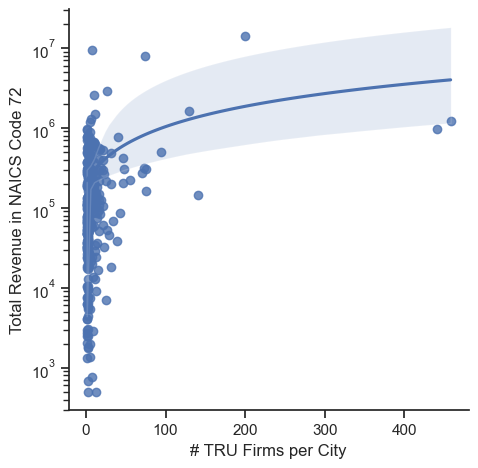

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="ticks")
varlabel = '72_RCPTOT'
subset = counts_and_census[~counts_and_census[varlabel].isin(['N','D'])]
subset[varlabel] = [float(str(x).replace(',','')) for x in subset[varlabel]]
# sns.jointplot(data=subset, x='Company', y=varlabel, kind="hex", color="#4CB391")
sns.lmplot(
    subset, x="Company", y=varlabel
)
plt.yscale('log')
plt.xlabel('# TRU Firms per City')
plt.ylabel('Total Revenue in NAICS Code 72')

In [32]:
places.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,clean_city
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,G4110,A,6148696,0,+34.2886519,-118.4362413,"POLYGON ((-118.45601 34.28490, -118.45414 34.2...",san fernando
1,06,14190,02409487,0614190,Cloverdale,Cloverdale city,25,C1,N,N,G4110,A,8107251,0,+38.7961433,-123.0150596,"POLYGON ((-123.03512 38.78701, -123.03510 38.7...",cloverdale
2,06,16560,02410240,0616560,Cotati,Cotati city,25,C1,N,N,G4110,A,4869301,8380,+38.3284920,-122.7100491,"POLYGON ((-122.72960 38.33349, -122.72951 38.3...",cotati
3,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56675175,26959120,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29711 34.34463, -119.2970...",san buenaventura (ventura)
4,06,30014,02410601,0630014,Glendora,Glendora city,25,C1,N,N,G4110,A,50527933,400123,+34.1449643,-117.8478035,"POLYGON ((-117.89005 34.14675, -117.89005 34.1...",glendora


In [9]:
places.head()

,STATEFP,PLACEFP,PLACENS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,PCICBSA,PCINECTA,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,clean_city
0,06,66140,02411785,0666140,San Fernando,San Fernando city,25,C1,N,N,G4110,A,6148696,0,+34.2886519,-118.4362413,"POLYGON ((-118.45601 34.28490, -118.45414 34.2...",san fernando
1,06,14190,02409487,0614190,Cloverdale,Cloverdale city,25,C1,N,N,G4110,A,8107251,0,+38.7961433,-123.0150596,"POLYGON ((-123.03512 38.78701, -123.03510 38.7...",cloverdale
2,06,16560,02410240,0616560,Cotati,Cotati city,25,C1,N,N,G4110,A,4869301,8380,+38.3284920,-122.7100491,"POLYGON ((-122.72960 38.33349, -122.72951 38.3...",cotati
3,06,65042,02411779,0665042,San Buenaventura (Ventura),San Buenaventura (Ventura) city,25,C1,Y,N,G4110,A,56675175,26959120,+34.2677796,-119.2542062,"MULTIPOLYGON (((-119.29711 34.34463, -119.2970...",san buenaventura (ventura)
4,06,30014,02410601,0630014,Glendora,Glendora city,25,C1,N,N,G4110,A,50527933,400123,+34.1449643,-117.8478035,"POLYGON ((-117.89005 34.14675, -117.89005 34.1...",glendora


In [4]:
census_data['2017 NAICS code (NAICS2017)'].unique()

array(['42', '44-45', '48-49 (106)', '51', '52', '53', '54', '56', '62',
       '71', '72', '81', '61', '22'], dtype=object)